### Attempt to engineer features for learning

        - Use DT as proxy with FI chart

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns
from sklearn import model_selection as sk
from sklearn import metrics as m
from sklearn import preprocessing as p
from sklearn import svm, linear_model, cluster, ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin

%store -r df 
%store -r x 
%store -r y

%store -r cols
%store -r testsizepercent
%store -r rs

## Functions

In [34]:
def plotUnivariateROC_cond(preds, truth, label_string, auc_del=.6):
    '''
    preds is an nx1 array of predictions
    truth is an nx1 array of truth labels
    label_string is text to go into the plotting label
    '''

    #1. call the roc_curve function to get the ROC X and Y values
    fpr, tpr, thresholds = m.roc_curve(truth, preds)
    
    #2. Input fpr and tpr into the auc function to get the AUC
    roc_auc = m.auc(fpr, tpr)
    
    #we are doing this as a special case because we are sending unfitted predictions
    #into the function
    if roc_auc < 0.5:
        fpr, tpr, thresholds = m.roc_curve(truth, -1 * preds)
        roc_auc = m.auc(fpr, tpr)

    if roc_auc>auc_del:    
        #chooses a random color for plotting
        c = (np.random.rand(), np.random.rand(), np.random.rand())

        #create a plot and set some options
        plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)


        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC')
        plt.legend(loc="lower right")
    
    return roc_auc

    
def plotMI(dat, lab, width = 0.35):
    '''
    Draw a bar chart of the normalized MI between each X and Y
    '''
    X = dat.drop(lab, 1)
    Y = dat[[lab]].values
    cols = X.columns.values
    mis = []

    #Start by getting MI
    for c in cols:
        mis.append(m.normalized_mutual_info_score(Y.ravel(), X[[c]].values.ravel()))

    #Get signs by correlation
    corrs = dat.corr()[lab]
    corrs[corrs.index != lab]
    df = pd.DataFrame(list(zip(mis, cols)), columns = ['MI', 'Lab'])
    df = pd.concat([df, pd.DataFrame(list(corrs), columns = ['corr'])], axis=1).reindex()
    makeBarSigned(df, 'MI', 'Lab', width)
    
def makeBarSigned(df, h, lab,  width):
    '''
    Contains
    '''
    df_s = df.sort_values(by = [h], ascending = False)

    #Get a barplot
    ind = np.arange(df_s.shape[0])
    labs = df_s[[lab]].values.ravel()
    h_pos = (df_s[['corr']].values.ravel() > 0) * df_s.MI
    h_neg = (df_s[['corr']].values.ravel() < 0) * df_s.MI

    fig = plt.figure(facecolor = 'w', figsize = (12, 6))
    ax = plt.subplot(111)
    plt.subplots_adjust(bottom = 0.25)

    rec = ax.bar(ind + width, h_pos, width, color='r', label = 'Positive')
    rec = ax.bar(ind + width, h_neg, width, color='b', label = 'Negative')

    ax.set_xticks(np.arange(25))
    ax.set_xticklabels(labs, rotation = 45, size = 14)

    plt.legend()
    
class CustomScaler(BaseEstimator,TransformerMixin): 
    def __init__(self,columns,copy=True,with_mean=True,with_std=True):
        self.scaler = p.StandardScaler(copy,with_mean,with_std)
        self.columns = columns

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns], y)
        return self

    def transform(self, X, y=None, copy=None):
        init_col_order = X.columns
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]), columns=self.columns)
        X_not_scaled = X.iloc[:,~X.columns.isin(self.columns)]
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]

## Building New Features
    
We add $x^2$, $x^3$, $e^x$ of each feature with some exceptions

- no new features for `fConc`, `fConc1`, `fSize`
- no exponential for `fDist`, `fAsym`

Yields 30 features 

In [3]:
#Add Features
fe_df = df.copy()
fe_cols = cols[0:10].copy()

In [4]:
for col in cols:
    if (col!='fConc'and col!='fConc1' and col!='fSize' and col!='Class'):  
        fe_df['x2_'+col]=fe_df.apply((lambda row: row[col]**2), axis=1)
        fe_df['x3_'+col]=fe_df.apply((lambda row: row[col]**3), axis=1)
        fe_cols.append('x2_'+col)
        fe_cols.append('x3_'+col)
        
fe_df['AbsConcs']=fe_df.apply((lambda row: (abs(row['fConc'])+abs(row['fConc1']))), axis=1)
fe_cols.append('AbsConcs')
fe_cols.append('Class')
fe_df = fe_df[fe_cols]

In [5]:
#Building Train/Test Splits of New Feature Data

fe_y = fe_df['Class']
fe_x = fe_df.drop('Class', 1)

x_fetr, x_fete, y_fetr, y_fete = sk.train_test_split(fe_x, fe_y, 
                                                     test_size=testsizepercent, 
                                                     stratify=fe_y)

### Analyze New Features 

#### Univariate

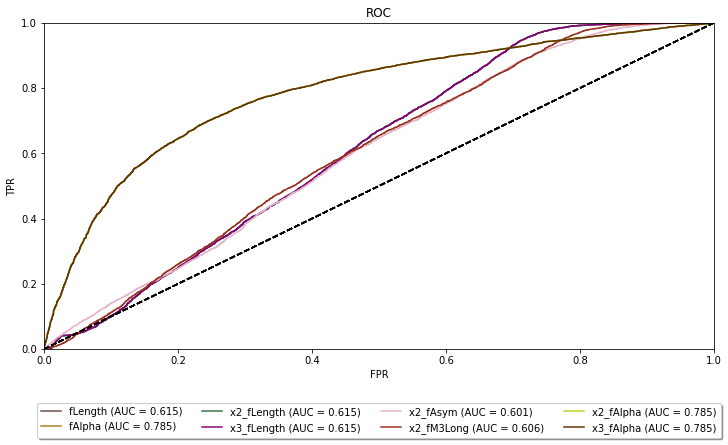

In [6]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

#Plot the univariate AUC on the training data. Store the AUC

feature_auc_dict = {}
for col in fe_x.columns:
    feature_auc_dict[col] = plotUnivariateROC_cond(fe_x[col], fe_y, col)


# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

### Mutual Information

In [7]:
#DT for feature importance

dt = DecisionTreeClassifier(criterion = 'entropy')
dt.fit(x_fetr, y_fetr)
feature_mi = dt.feature_importances_
feature_mi_dict = dict(zip(fe_x.columns.values, feature_mi))


In [37]:
fe_cols

['fLength',
 'fWidth',
 'fSize',
 'fConc',
 'fConc1',
 'fAsym',
 'fM3Long',
 'fM3Trans',
 'fAlpha',
 'fDist',
 'x2_fLength',
 'x3_fLength',
 'x2_fWidth',
 'x3_fWidth',
 'x2_fAsym',
 'x3_fAsym',
 'x2_fM3Long',
 'x3_fM3Long',
 'x2_fM3Trans',
 'x3_fM3Trans',
 'x2_fAlpha',
 'x3_fAlpha',
 'x2_fDist',
 'x3_fDist',
 'AbsConcs',
 'Class']

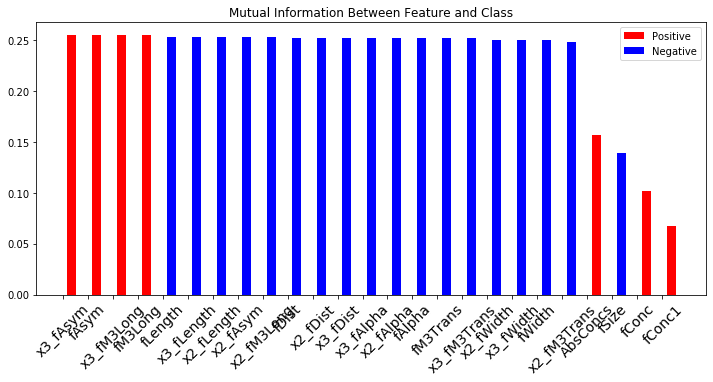

In [35]:
import warnings
warnings.filterwarnings('ignore')

plotMI(fe_df, 'Class')
ax.set_xticklabels(fe_cols, rotation = 45, size = 10)
plt.title('Mutual Information Between Feature and Class')
plt.show()

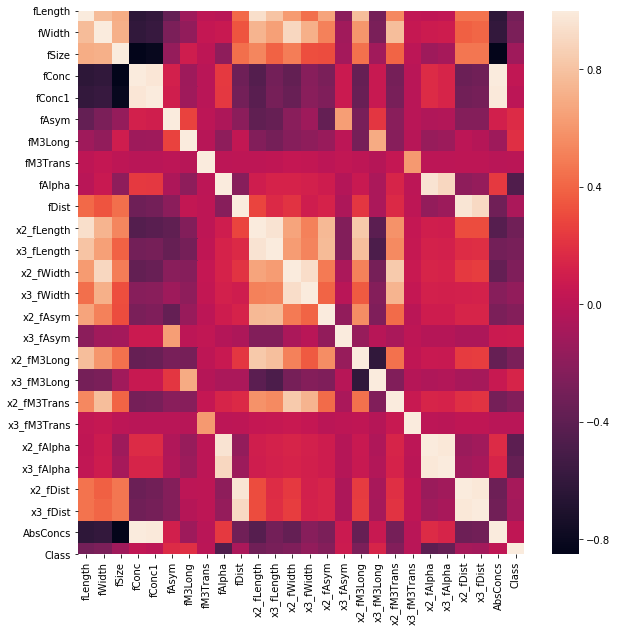

In [9]:
fig, ax = plt.subplots(figsize=(10,10))     
sns.heatmap(fe_df.corr(), annot=False)

## Resampling

- Balancing Class Quantities in Data

In [10]:
df_gamma = df[df['Class']==1]
df_hadron = df[df['Class']==0]

In [11]:
df_hadron_upsampled = resample(df_hadron, 
                                 replace=True,     # sample with replacement
                                 n_samples=12332)    # to match majority

In [12]:
df_gamma

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,Class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1
...,...,...,...,...,...,...,...,...,...,...,...
12327,12.8703,11.4444,2.3811,0.7360,0.3805,-15.0946,5.3032,11.6208,21.0120,204.0370,1
12328,26.8595,20.5946,2.8754,0.3438,0.2152,-3.4556,-20.0014,-9.0535,3.9848,205.4980,1
12329,22.0913,10.8949,2.2945,0.5381,0.2919,15.2776,18.2296,7.3975,21.0680,123.2810,1
12330,56.2216,18.7019,2.9297,0.2516,0.1393,96.5758,-41.2969,11.3764,5.9110,197.2090,1


In [13]:
df_hadron_upsampled

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,Class
19003,21.5189,15.4205,2.7328,0.5587,0.3117,-7.3668,9.2409,17.1609,80.4307,223.9730,0
14781,27.1366,15.5445,2.5078,0.6697,0.4359,16.5055,-5.6294,-0.2316,13.4866,207.5123,0
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,0
16544,136.1294,33.9589,3.3121,0.2134,0.1053,-75.1637,-87.9102,32.7287,4.2428,260.9902,0
13081,30.8329,22.0892,2.3942,0.3555,0.1731,21.2582,9.1749,9.0501,63.5579,51.0149,0
...,...,...,...,...,...,...,...,...,...,...,...
13864,233.0940,33.1213,3.4052,0.1125,0.0572,208.6280,217.9340,8.6180,65.1453,78.0064,0
14929,57.6556,33.2475,3.2526,0.2976,0.1868,17.8991,38.2299,14.8958,71.9083,173.7475,0
12507,240.4620,134.0840,3.5814,0.1324,0.0762,-179.1440,-142.7090,-132.4160,26.9020,138.6600,0
14053,58.8706,20.0434,2.9299,0.2456,0.1416,-21.6574,-45.6059,16.4317,28.2421,192.8620,0


In [14]:
up_df = pd.concat([df_gamma, df_hadron_upsampled], ignore_index=True)

In [15]:
up_df['Class'].value_counts()

1    12332
0    12332
Name: Class, dtype: int64

In [16]:
#Building Train/Test Splits of Upsampled Data

up_y = up_df['Class']
up_x = up_df.drop('Class', 1)


x_uptr, x_upte, y_uptr, y_upte = sk.train_test_split(up_x, up_y, 
                                                     test_size=testsizepercent, 
                                                     stratify=up_y)

In [17]:
up_df[up_df['Class']==0]

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,Class
12332,21.5189,15.4205,2.7328,0.5587,0.3117,-7.3668,9.2409,17.1609,80.4307,223.9730,0
12333,27.1366,15.5445,2.5078,0.6697,0.4359,16.5055,-5.6294,-0.2316,13.4866,207.5123,0
12334,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,0
12335,136.1294,33.9589,3.3121,0.2134,0.1053,-75.1637,-87.9102,32.7287,4.2428,260.9902,0
12336,30.8329,22.0892,2.3942,0.3555,0.1731,21.2582,9.1749,9.0501,63.5579,51.0149,0
...,...,...,...,...,...,...,...,...,...,...,...
24659,233.0940,33.1213,3.4052,0.1125,0.0572,208.6280,217.9340,8.6180,65.1453,78.0064,0
24660,57.6556,33.2475,3.2526,0.2976,0.1868,17.8991,38.2299,14.8958,71.9083,173.7475,0
24661,240.4620,134.0840,3.5814,0.1324,0.0762,-179.1440,-142.7090,-132.4160,26.9020,138.6600,0
24662,58.8706,20.0434,2.9299,0.2456,0.1416,-21.6574,-45.6059,16.4317,28.2421,192.8620,0


## Visualize Upsample

- all looks the same

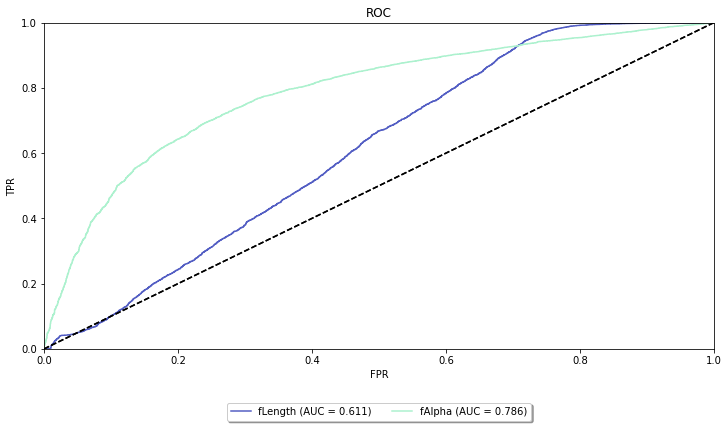

In [18]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

#Plot the univariate AUC on the training data. Store the AUC


feature_auc_dict = {}
for col in up_df.drop('Class',1).columns:
    feature_auc_dict[col] = plotUnivariateROC_cond(up_df[col], up_df['Class'], col)


# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

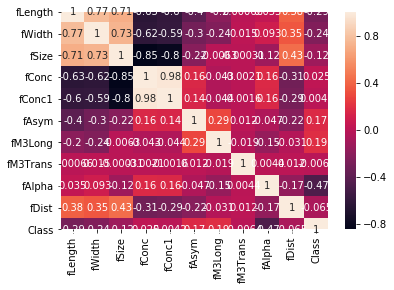

In [19]:
sns.heatmap(up_df.corr(), annot=True)

Text(0.5, 1.0, 'Mutual Information Between Feature and Class - M^F')

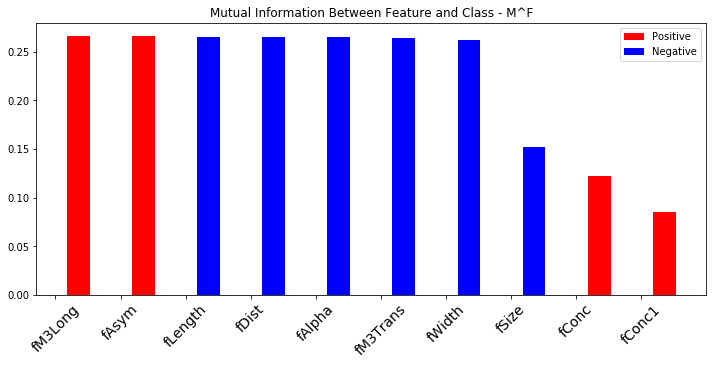

In [20]:
#DT for feature importance

dt_u = DecisionTreeClassifier(criterion = 'entropy')
dt_u.fit(up_df.drop('Class',1),up_df['Class'])
feature_mi = dt_u.feature_importances_
feature_mi_dict = dict(zip(up_df.drop('Class',1).columns.values, feature_mi))

import warnings
warnings.filterwarnings('ignore')

plotMI(up_df, 'Class')
plt.title('Mutual Information Between Feature and Class - M^F')

## Scaling

In [21]:
scale = CustomScaler(columns=fe_cols[0:25])
fedf_sc = scale.fit_transform(fe_df)

fe_ys = fedf_sc['Class']
fe_xs = fedf_sc.drop('Class', 1)

xs_fetr, xs_fete, ys_fetr, ys_fete = sk.train_test_split(fe_xs, fe_ys, 
                                                     test_size=testsizepercent, 
                                                     stratify=fe_ys)

In [22]:
scale = CustomScaler(columns=cols[0:10])
updf_sc = scale.fit_transform(up_df)

up_ys = updf_sc['Class']
up_xs = updf_sc.drop('Class', 1)

xs_uptr, xs_upte, ys_uptr, ys_upte = sk.train_test_split(up_xs, up_ys, 
                                                     test_size=testsizepercent, 
                                                     stratify=up_ys)

## Storing Variables

In [23]:
#Feature Engineering Results

#New Features
%store fe_df
%store fe_x
%store fe_y
%store x_fetr
%store y_fetr
%store x_fete
%store y_fete

#New Features- scaled
%store fedf_sc
%store fe_xs
%store fe_ys
%store xs_fetr
%store ys_fetr
%store xs_fete
%store ys_fete

#Upsampled Data
%store up_df
%store up_x
%store up_y
%store x_uptr
%store y_uptr
%store x_upte
%store y_upte

#Upsampled Data - scaled
%store updf_sc
%store up_xs
%store up_ys
%store xs_uptr
%store ys_uptr
%store xs_upte
%store ys_upte

%store fe_cols

Stored 'fe_df' (DataFrame)
Stored 'fe_x' (DataFrame)
Stored 'fe_y' (Series)
Stored 'x_fetr' (DataFrame)
Stored 'y_fetr' (Series)
Stored 'x_fete' (DataFrame)
Stored 'y_fete' (Series)
Stored 'fedf_sc' (DataFrame)
Stored 'fe_xs' (DataFrame)
Stored 'fe_ys' (Series)
Stored 'xs_fetr' (DataFrame)
Stored 'ys_fetr' (Series)
Stored 'xs_fete' (DataFrame)
Stored 'ys_fete' (Series)
Stored 'up_df' (DataFrame)
Stored 'up_x' (DataFrame)
Stored 'up_y' (Series)
Stored 'x_uptr' (DataFrame)
Stored 'y_uptr' (Series)
Stored 'x_upte' (DataFrame)
Stored 'y_upte' (Series)
Stored 'updf_sc' (DataFrame)
Stored 'up_xs' (DataFrame)
Stored 'up_ys' (Series)
Stored 'xs_uptr' (DataFrame)
Stored 'ys_uptr' (Series)
Stored 'xs_upte' (DataFrame)
Stored 'ys_upte' (Series)
Stored 'fe_cols' (list)
